In [ ]:
# implementing PyTorch Lightning to streamline the model

# MNIST PyTorch model by building custom Dataset subclass
# built-in MNIST PyTorch Dataset subclass available on torchvision.dataset; this is for practice
# MNIST datasets in CSV form accessed at https://github.com/phoebetronic/mnist

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import random
import pytorch_lightning as pl
from torchmetrics import Accuracy

In [ ]:
class MyDataset(Dataset):

    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file, delimiter=",", header = None)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        entry = self.df.iloc[index]
        image_in_1D = torch.from_numpy(entry[1:].to_numpy())
        image_in_3D = torch.reshape(image_in_1D, (1, 28, 28))
        image = image_in_3D / 255
        label = torch.tensor(entry[0])
        return image, label

In [ ]:
train_dataset = MyDataset("mnist_train.csv")
test_dataset = MyDataset("mnist_test.csv")
train_dataloader = DataLoader(train_dataset, batch_size = 100, shuffle = True) 
test_dataloader = DataLoader(test_dataset, batch_size = 100, shuffle = False) 

In [ ]:
# http://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/
# with amendments made to fit my 1 channel, 28x28 pixel images

class MyModel(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 28, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(28, 28, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.flat = nn.Flatten()
        
        self.fc3 = nn.Linear(5488, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        
        # input 1x28x28, output 28x28x28
        x = self.act1(self.conv1(x))
        x = self.drop1(x)     
        
        # input 28x28x28, output 28x28x28
        x = self.act2(self.conv2(x))
        
        # input 28x28x28, output 28x14x14
        x = self.pool2(x)
        
        # input 28x14x14, output 5488
        x = self.flat(x)
        
        # input 5488, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        
        # input 512, output 10
        x = self.fc4(x)
        
        return x

In [ ]:
class MyLightning(pl.LightningModule):

    def __init__(self, model, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()
        self.acc_fn = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, true_labels = batch
        pred_labels = self(features)
        loss = self.loss_fn(pred_labels, true_labels)
        self.log("train_loss", loss, on_epoch=True)
        accuracy = self.acc_fn(pred_labels,true_labels)
        self.log("train_acc", accuracy, on_epoch=True)      
        return loss        
    
    def validation_step(self, batch, batch_idx):
        features, true_labels = batch
        pred_labels = self(features)
        loss =  self.loss_fn(pred_labels, true_labels)
        self.log("val_loss", loss, on_epoch=True)
        accuracy = self.acc_fn(pred_labels,true_labels)
        self.log("val_acc", accuracy, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr = self.learning_rate)
        return optimizer

pytorch_model = MyModel()
lightning_model = MyLightning(model=pytorch_model, learning_rate=1e-3)
trainer = pl.Trainer(max_epochs=5, accelerator="auto", devices="auto")
trainer.fit(model=lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)

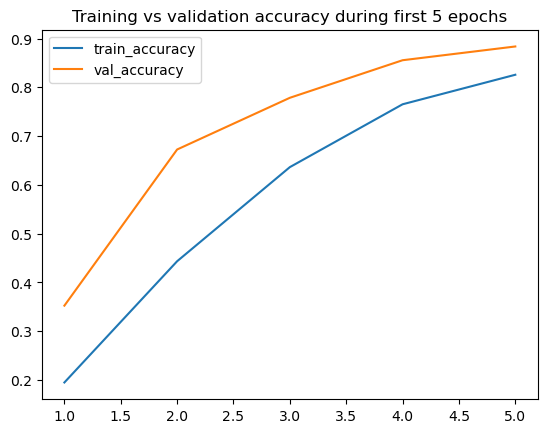

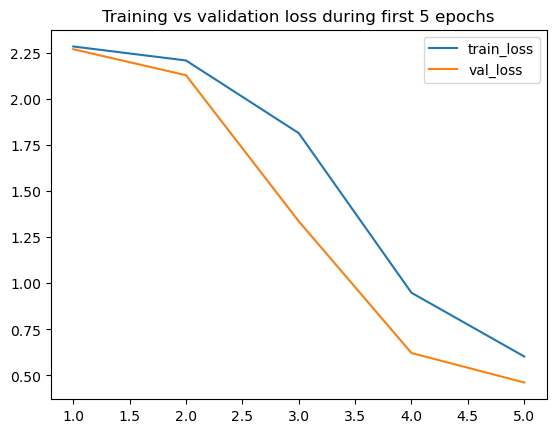

In [9]:
# plotting accuracy, loss curves from logged data

metrics = pd.read_csv("lightning_logs/version_18/metrics.csv")

train_accuracy = np.zeros(5)
train_loss = np.zeros(5)
val_accuracy = np.zeros(5)
val_loss = np.zeros(5)

for i in range(5):
    train_accuracy[i] = metrics.iloc[13+(14*i)].iloc[2].item()
    train_loss[i] = metrics.iloc[13+(14*i)].iloc[4].item()
    val_accuracy[i] = metrics.iloc[12+(14*i)].iloc[-2].item()
    val_loss[i] = metrics.iloc[12+(14*i)].iloc[-1].item()

# print(train_accuracy)
# print(val_accuracy)
# print(train_loss)
# print(val_loss)

epochs = np.array([1,2,3,4,5])

plt.plot(epochs, train_accuracy, label="train_accuracy")
plt.plot(epochs, val_accuracy, label="val_accuracy")
plt.title("Training vs validation accuracy during first 5 epochs")
plt.legend()
plt.show()

plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.title("Training vs validation loss during first 5 epochs")
plt.legend()
plt.show()